In [1]:
import numpy as np
import cv2
import math
import os
import matplotlib.pyplot as plt

In [2]:
# Camera Calibration
calib_file = 'camera_cal/'
calib_img = os.listdir(calib_file)

nx = 9
ny = 6

image_points = []
object_points = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for image_name in calib_img:
    
    image = cv2.imread(calib_file + image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(objp)

In [3]:
ret, mtx, dist, rvecs, tvects = cv2.calibrateCamera(object_points, image_points, gray.shape, None, None)

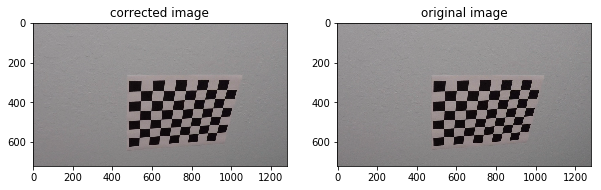

In [4]:
# undistort two example images:
img = cv2.imread(calib_file + calib_img[1])
dst = cv2.undistort(img, mtx, dist,None, mtx)

fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(dst)
axs[0].set_title('corrected image')
axs[1].imshow(img)
axs[1].set_title('original image')

In [435]:
# Select one of the images from the test images folder to start implementing advanced lane finding method
test_images_file = "test_images/"
test_images = os.listdir(test_images_file)

image_name = test_images_file + test_images[7]
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [436]:
# Undistord the selected test image
undist_image = cv2.undistort(image, mtx, dist, None, mtx)

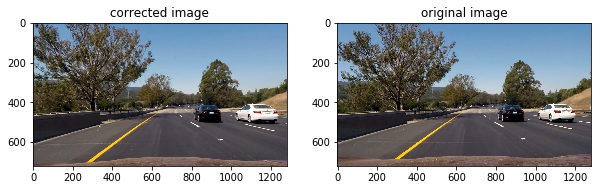

In [437]:
fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(undist_image)
axs[0].set_title('corrected image')
axs[1].imshow(image)
axs[1].set_title('original image')

In [438]:
# Color Threshold on HLS(Hue, Lightness, saturation) images 
HLS_img = cv2.cvtColor(undist_image, cv2.COLOR_BGR2HLS)

H_channel = HLS_img[:,:,0]
L_channel = HLS_img[:,:,1]
S_channel = HLS_img[:,:,2]

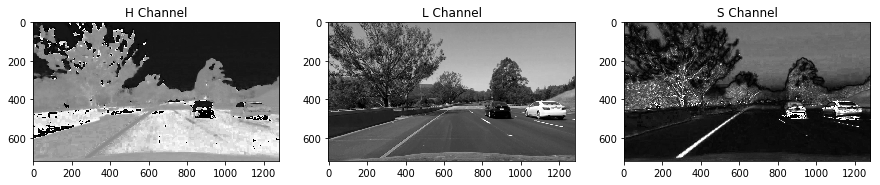

In [439]:
fig, axs = plt.subplots(1,3, figsize = (15,6))
axs = axs.ravel()

axs[0].imshow(H_channel, cmap = 'gray')
axs[0].set_title('H Channel')

axs[1].imshow(L_channel, cmap = 'gray')
axs[1].set_title("L Channel")

axs[2].imshow(S_channel, cmap = 'gray')
axs[2].set_title('S Channel')


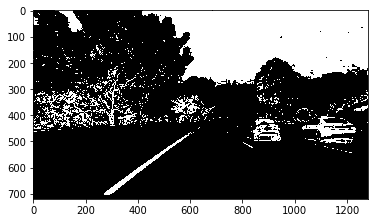

In [440]:
# Threshold the S channel
thresh = (100, 255)
S_binary = np.zeros_like(S_channel)
S_binary[(S_channel>thresh[0]) & (S_channel<=thresh[1])] = 1

plt.imshow(S_binary, cmap = 'gray')

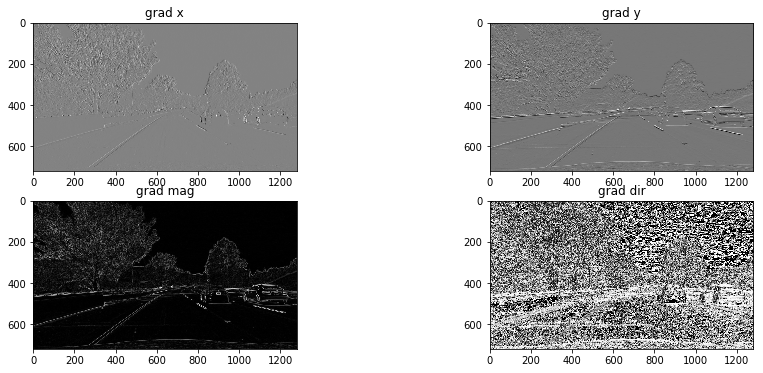

In [441]:
# Gradiend Threshold
gray_img = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)

grad_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)

grad_mag = np.sqrt(grad_x**2 + grad_y**2)
grad_dir = np.arctan2(np.abs(grad_y),np.abs(grad_x))

fig, axs = plt.subplots(2,2, figsize = (15,6))
axs = axs.ravel()

axs[0].imshow(grad_x, cmap = 'gray')
axs[0]. set_title("grad x")

axs[1].imshow(grad_y, cmap = 'gray')
axs[1]. set_title("grad y")


axs[2].imshow(grad_mag, cmap = 'gray')
axs[2]. set_title("grad mag")

axs[3].imshow(grad_dir, cmap = 'gray')
axs[3]. set_title("grad dir")

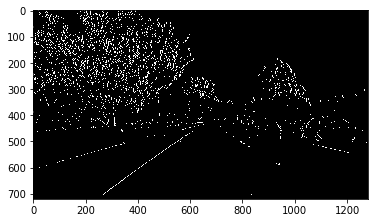

In [442]:
# Threshold the grad x
thresh = (90, 255)
binary_gradx = np.zeros_like(grad_x)
binary_gradx[(grad_x>= thresh[0]) & (grad_x<= thresh[1])] = 1

plt.imshow(binary_gradx, cmap= 'gray')

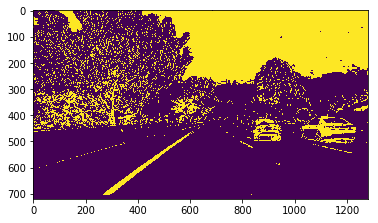

In [443]:
# Combine the Color Threshold and the gradient threshold
binary_img = np.zeros_like(S_binary)

binary_img[(S_binary ==1) | (binary_gradx ==1)] = 1

plt.imshow(binary_img)

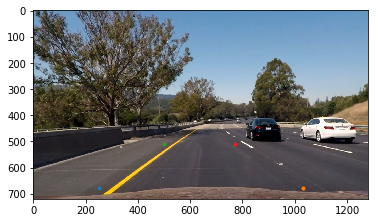

(720, 1280, 3)


In [444]:
# Use perespective transform to obtain a birds eye view of the road



plt.imshow(undist_image)
plt.plot(250, 680,'.')
plt.plot(1030, 680,'.')
plt.plot(500, 510,'.')
plt.plot(770,510,'.')
plt.show()


print(undist_image.shape)

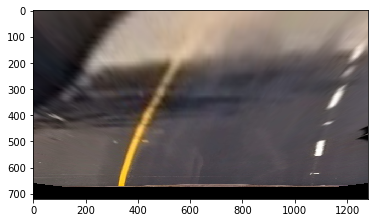

In [445]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[308, 658],
                     [998, 658],
                     [532, 500],
                     [759,500]])
    
    dst = np.float32(
    [[308, 658],
     [998, 658],
     [325, 500],
     [990, 500]])
    

    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped, Minv

bird_eye, Minv = warp(undist_image)

plt.imshow(bird_eye)

In [446]:
def HLS_threshold (img, thresh):
    HLS_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    S_channel = HLS_img[:,:,2]
    
    S_binary = np.zeros_like(S_channel)
    S_binary[(S_channel >= thresh[0]) & (S_channel <= thresh[1])] = 1
    return S_binary

In [447]:
def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        grad = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    else:
        grad = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        
    grad_binary = np.zeros_like(gray_img)
    
    grad_binary[(grad > thresh[0]) & (grad <= thresh[1])] = 1
    
    return grad_binary

In [448]:
def mag_thresh(img, sobel_kernel = 3, thresh = (0, 255)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    grad_x = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_mag = (255*grad_mag/np.max(grad_mag))
    
    mag_binary = np.zeros_like(gray_img)
    mag_binary[(grad_mag > thresh[0]) & (grad_mag <= thresh[1])] = 1
    
    return mag_binary

In [449]:
def dir_thresh(img, sobel_kernel = 3, thresh = (-np.pi/2, np.pi/2)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    grad_x = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    
    
    grad_dir = np.arctan2(np.abs(grad_y), np.abs(grad_x))
    
    dir_binary = np.zeros_like(gray_img)
    dir_binary[(grad_dir > thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return dir_binary

In [450]:
def grad_thresh(img, thresh_x, thresh_y, thresh_m, thresh_d):
    
    gradx = abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = thresh_x)
    grady = abs_sobel_thresh(img, orient = 'y', sobel_kernel = 3, thresh = thresh_y)
    mag_binary = mag_thresh(img, sobel_kernel = 3, thresh = thresh_m)
    dir_binary = dir_thresh(img, sobel_kernel = 3, thresh = thresh_d)
    
    combined_binary = np.zeros_like(gradx)
    
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_binary

In [451]:
def combine_thresholds(binary_1, binary_2):
    final_binary = np.zeros_like(binary_1)
    
    final_binary[(binary_1 == 1) | (binary_2 == 1)] = 1
    
    return final_binary

In [452]:
def Generate_Binary_Warped(img):
    
    corrected_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    Color_binary = HLS_threshold(corrected_img, (200, 255))
    Grad_binary = grad_thresh(corrected_img, (30, 255), (200, 255), (60, 255), (0.35, 1.57))
    
    combined_binary = combine_thresholds(Color_binary, Grad_binary)
    
    result, Minv = warp(combined_binary)
  
    
    return result

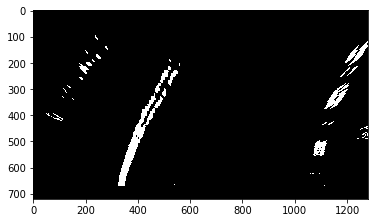

In [453]:
my_image = cv2.imread(image_name)
binary_warped = Generate_Binary_Warped(my_image)

plt.imshow(binary_warped, cmap = 'gray')

In [454]:
def Image_Lane_detection(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

In [455]:
left_fit, right_fit, leftx, lefty, rightx, righty = Image_Lane_detection(binary_warped)

(720, 0)

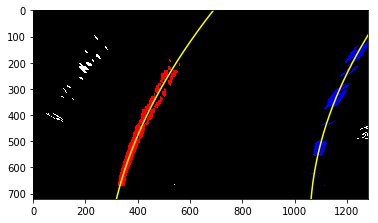

In [456]:
# Generate x and y values for plotting
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

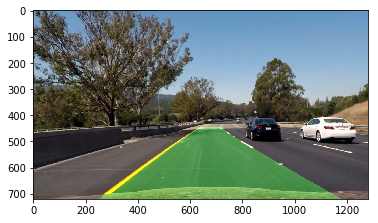

In [457]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [458]:
def Frame_Lane_detection(binary_warped, left_fit , right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

In [459]:
left_fit, right_fit, leftx, lefty, rightx, righty = Frame_Lane_detection(binary_warped, left_fit, right_fit)

(720, 0)

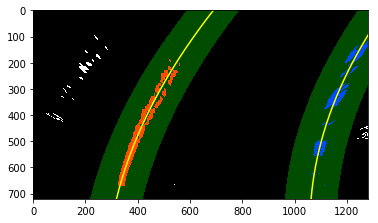

In [460]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [461]:
def Lane_Curveture(leftx, lefty, rightx, righty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

In [462]:
left_curverad, right_curverad = Lane_Curveture(leftx, lefty, rightx, righty)

print(left_curverad, 'm', right_curverad, 'm')

440.142087427 m 389.113868483 m
